# 프로젝트 : 다양한 OCR모델 비교하기
================================================================================

# 목차
>## 1. 데이터셋 준비
>## 2. keras_OCR 활용하기
>## 3. 테서렉트 활용하기
>## 4. 결과 확인
>## 5. 결과 요약
>## 6. 회고
>## 7. Reference
>## 8. 자기다짐 및 아쉬운 점

---

## 루브릭 평가 기준
- 1. OCR을 활용하여 구현하려는 서비스의 기획이 타당한가?
    - 기획한 서비스가 OCR 적용 가능한 서비스이며, OCR 기술을 활용했을 때 더 유용한지에 대한 타당성 여부를 기술하였다.
- 2. 모델 평가기준이 명확하고 체계적으로 세워졌는가?
    - 앞서 기획한 서비스에서 OCR 모델들이 그 목적에 부합하는지 확인하기 위해 필요한 평가 기준을 제시하고, 평가기준에 적합한 테스트 데이터의 특징이 무엇인지 설명하였다.
- 3. 평가기준에 따라 충분한 분량의 테스트가 진행되고 그 결과가 잘 정리되었는가?
    - 최대 20장까지의 테스트 이미지를 사용해 제시된 평가 기준에 따른 테스트 결과가 잘 정리되어 결론이 도출되었다.
    
---

## 1. 데이터셋 준비

In [1]:
import matplotlib.pyplot as plt
import keras_ocr
import os
import pytesseract
from PIL import Image
from pytesseract import Output

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


- OCR에 필요한 모듈들과 pipeline을 변수에 할당해 주겠습니다.

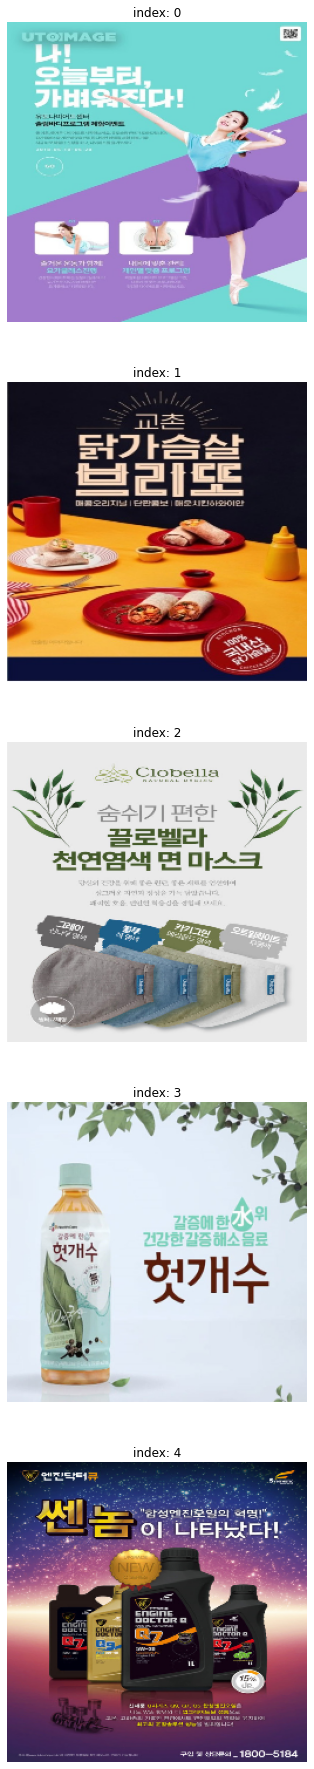

In [2]:
import cv2

plt.figure(figsize=(48,32))
img_path = './images/'
path_list = []

for i in range(5):
    img = cv2.imread(img_path + 'test_{}.jfif'.format(i+1))
    path_list.append(img_path + 'test_{}.jfif'.format(i+1))
    img = cv2.resize(img, (256,256))
    plt.subplot(5, 1, i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

- 위 이미지 5장을 준비하였습니다.
- 글씨 폰트, 크기, 색상, 그림자효과 등 노이즈가 들어있는 이미지로 선택하였습니다.
- 제 목적은 인터넷에서 무작위 크롤링하여 수집한 이미지에서 특정 단어를 추출해 카테고리별 분류를 하는 기능을 만들어보고 싶었습니다.
  
  
- 그러기 위해선 __특정 단어가 잘 분리 되었는지?__ 를 가장 중요하게 보겠습니다.

---
## 2. keras_OCR 활용하기

In [3]:
images = [ keras_ocr.tools.read(image) for image in path_list]
prediction_groups = [pipeline.recognize([image]) for image in path_list]

- 이미지를 추출하고 이미지에서 문자 주석을 추출한 prediction_groups를 만들어 주었습니다.

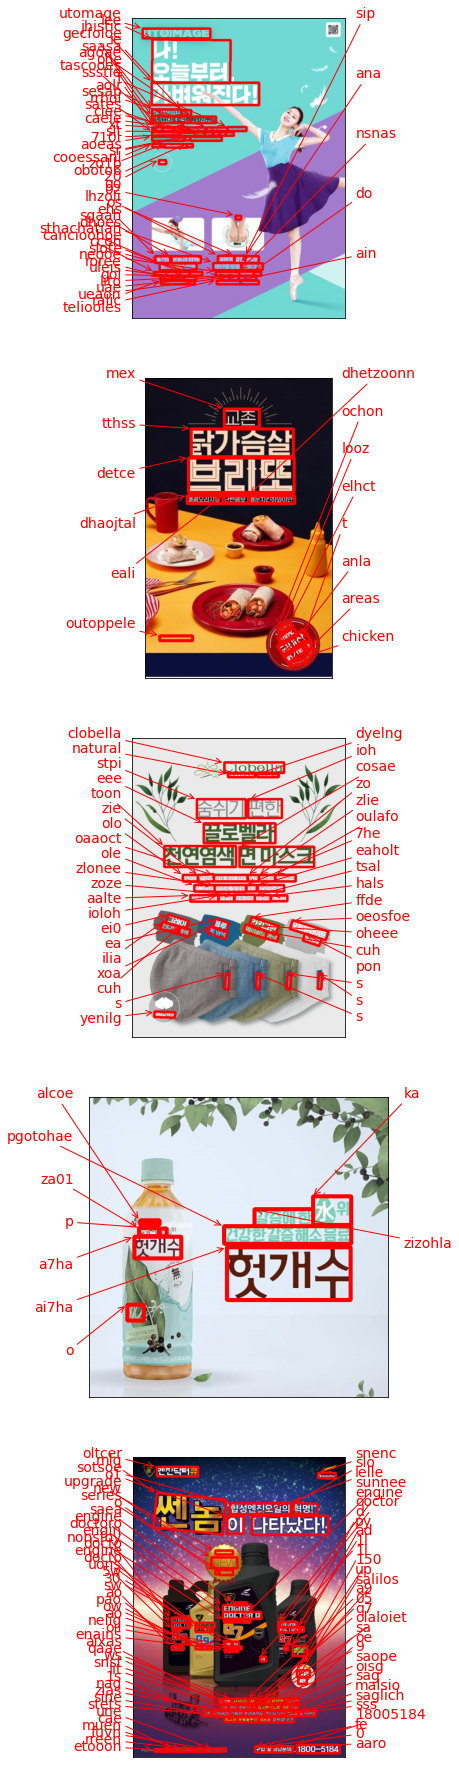

In [4]:
fig, axs = plt.subplots(nrows=len(images), figsize=(48, 32))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

- 무언가 추출은 잘 되었으나.. 한국어 이슈가 있다더니 정말이었군요 ㅠㅠ..
- 안타깝게도 keras_ocr 모델은 사용할 수 없을듯합니다.

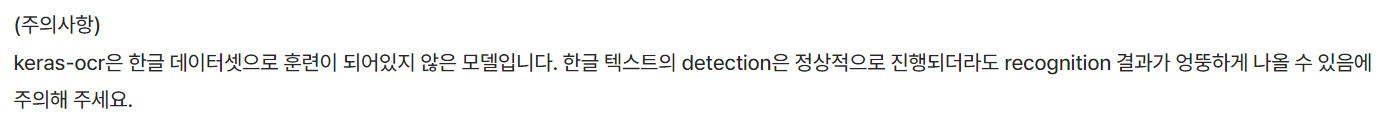

---
## 3. 테서렉트 활용하기

In [5]:
def crop_word_regions(image_path, output_path, num = 1, idx = 1):
    for i in range(num):
        if not os.path.exists(output_path):
            os.mkdir(output_path)
        outputs_path = output_path + '/test_{}'.format(idx)
        custom_oem_psm_config = r'--oem 3 --psm 3'
        img_path = image_path + '/test_{}.jfif'.format(idx)
        image = Image.open(img_path)
    
        recognized_data = pytesseract.image_to_data(
            image, lang='kor',
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print('추출한 텍스트 데이터 :', recognized_data['text'])
        print('\n')
        
        top_level = max(recognized_data['level'])
        cropped_image_path_list = []
        index = 0
        for i in range(len(recognized_data['level'])):
            level = recognized_data['level'][i]
        
            if level == top_level:
                left = recognized_data['left'][i]
                top = recognized_data['top'][i]
                width = recognized_data['width'][i]
                height = recognized_data['height'][i]
                
                output_img_path = os.path.join(outputs_path, f"{str(index).zfill(4)}.png")
                print('추출한 이미지: ', output_img_path)
                cropped_image = image.crop((
                    left,
                    top,
                    left+width,
                    top+height
                ))
                cropped_image.save(output_img_path)
                cropped_image_path_list.append(output_img_path)
                index +=1
                
        print('****'*24)
        print('{}번째 이미지 추출 완료'.format(idx))
        print('----'*24)
        idx += 1
                
    return cropped_image_path_list


work_dir = './images/ts'
image_path = './images'

- 이번엔 테서렉트를 활용해보겠습니다.
- 테서렉트를 이용해 각 글자들을 추출한 후 추출 구역을 crop한 이미지로 만들어주는 함수입니다. LMS 함수를 참고하여 약간의 수정을 걸쳐 만들었습니다.

### 여기서 oem_psm 이란?

### OCR Engine modes(–oem):
- 0 - Legacy engine only.
- 1 - Neural nets LSTM engine only.
- 2 - Legacy + LSTM engines.
- 3 - Default, based on what is available.

#### Page segmentation modes(–psm):
- 0 - Orientation and script detection (OSD) only.
- 1 - Automatic page segmentation with OSD.
- 2 - Automatic page segmentation, but no OSD, or OCR.
- 3 - Fully automatic page segmentation, but no OSD. (Default)
- 4 - Assume a single column of text of variable sizes.
- 5 - Assume a single uniform block of vertically aligned text.
- 6 - Assume a single uniform block of text.
- 7 - Treat the image as a single text line.
- 8 - Treat the image as a single word.
- 9 - Treat the image as a single word in a circle.
- 10 - Treat the image as a single character.
- 11 - Sparse text. Find as much text as possible in no particular order.
- 12 - Sparse text with OSD.
- 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.
  
  
- 을 의미하며 oem 1, psm 3 을 선택하면 RCNN 모델이 되는듯 하다고 이해했습니다.

In [6]:
cropped_image_path_list = crop_word_regions(image_path, work_dir, num = 5, idx = 1)

추출한 텍스트 데이터 : ['', '', '', '', ' ', '', ' ', '', '', '', '수', '', '유', '토', '다', '이', '어', '트', '센터', ',', ')', '', '오', '미', '다', '프', '토', '검', '제', '번', '이', '베', '트', '렀', '', '', '', '']


추출한 이미지:  ./images/ts/test_1/0000.png
추출한 이미지:  ./images/ts/test_1/0001.png
추출한 이미지:  ./images/ts/test_1/0002.png
추출한 이미지:  ./images/ts/test_1/0003.png
추출한 이미지:  ./images/ts/test_1/0004.png
추출한 이미지:  ./images/ts/test_1/0005.png
추출한 이미지:  ./images/ts/test_1/0006.png
추출한 이미지:  ./images/ts/test_1/0007.png
추출한 이미지:  ./images/ts/test_1/0008.png
추출한 이미지:  ./images/ts/test_1/0009.png
추출한 이미지:  ./images/ts/test_1/0010.png
추출한 이미지:  ./images/ts/test_1/0011.png
추출한 이미지:  ./images/ts/test_1/0012.png
추출한 이미지:  ./images/ts/test_1/0013.png
추출한 이미지:  ./images/ts/test_1/0014.png
추출한 이미지:  ./images/ts/test_1/0015.png
추출한 이미지:  ./images/ts/test_1/0016.png
추출한 이미지:  ./images/ts/test_1/0017.png
추출한 이미지:  ./images/ts/test_1/0018.png
추출한 이미지:  ./images/ts/test_1/0019.png
추출한 이미지:  ./images/ts/test_1/0020.png
추출한 이미지:

- 이미지를 모두 추출하였습니다. 각 이미지별로 crop된 이미지 갯수가 천차만별이군요 한번 확인해보도록 하겠습니다!

------------------------------------------------------------------------------------------------
첫번째 이미지 원본
------------------------------------------------------------------------------------------------


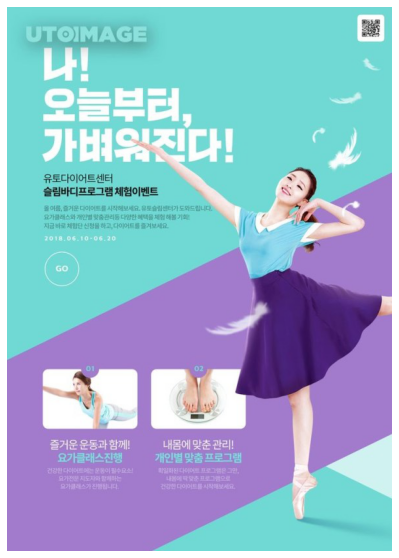

------------------------------------------------------------------------------------------------
추출한 이미지 목록
------------------------------------------------------------------------------------------------


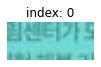

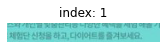

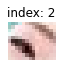

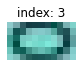

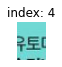

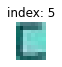

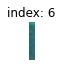

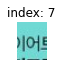

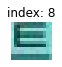

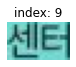

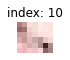

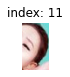

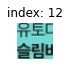

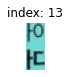

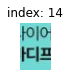

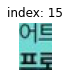

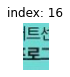

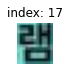

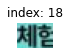

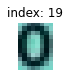

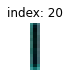

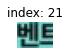

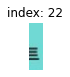

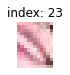

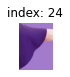

In [7]:
plt.figure(figsize=(10,10))
crop_img_path = './images/ts/test_1/'

print('----'*24)
print('첫번째 이미지 원본')
print('----'*24)
img = plt.imread('./images/test_1.jfif')
plt.imshow(img)
plt.axis('off')
plt.show()
print('----'*24)
print('추출한 이미지 목록')
print('----'*24)
for i in range(25):
    if i < 10:
        img = cv2.imread(crop_img_path + '000{}.png'.format(i))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(5, 2, i+1)
        plt.imshow(img)
        plt.title(f'index: {i}')
        plt.axis('off')
        plt.show()
    elif 10 <= i < 100:
        img = cv2.imread(crop_img_path + '00{}.png'.format(i))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(4, 8, i+1)
        plt.imshow(img)
        plt.title(f'index: {i}')
        plt.axis('off')
        plt.show()        

- 다이어트, 센터, 이벤트, 슬림, 체험 등등 유의미한 텍스트를 꽤나 잘 추출한듯합니다. 하지만 쓸모없는 얼굴, 팔 같은 부분의 이미지도 있군요.
  
  
- 두번째 이미지도 확인해 보겠습니다.

------------------------------------------------------------------------------------------------
두번째 이미지 원본
------------------------------------------------------------------------------------------------


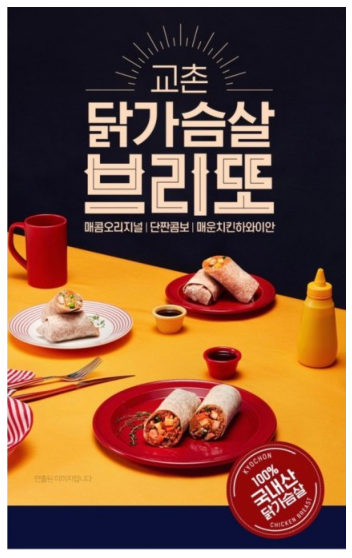

------------------------------------------------------------------------------------------------
추출한 이미지 목록
------------------------------------------------------------------------------------------------


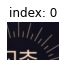

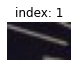

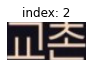

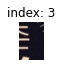

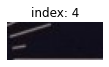

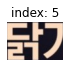

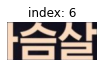

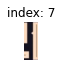

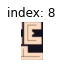

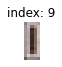

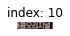

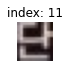

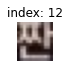

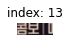

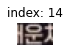

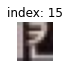

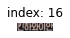

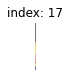

In [8]:
plt.figure(figsize=(10,10))
crop_img_path = './images/ts/test_2/'

print('----'*24)
print('두번째 이미지 원본')
print('----'*24)
img = plt.imread('./images/test_2.jfif')
plt.imshow(img)
plt.axis('off')
plt.show()
print('----'*24)
print('추출한 이미지 목록')
print('----'*24)
for i in range(18):
    if i < 10:
        img = cv2.imread(crop_img_path + '000{}.png'.format(i))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(5, 2, i+1)
        plt.imshow(img)
        plt.title(f'index: {i}')
        plt.axis('off')
        plt.show()
    elif 10 <= i < 100:
        img = cv2.imread(crop_img_path + '00{}.png'.format(i))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(4, 8, i+1)
        plt.imshow(img)
        plt.title(f'index: {i}')
        plt.axis('off')
        plt.show()        

- 교촌, 닭가슴살, 단, 짠, 콤보, 하와이안 등 유의미한 단어를 꽤나 추출했군요! 아주 괜찮은듯 합니다.
  
  
- 세번째 이미지도 확인해 보겠습니다.

------------------------------------------------------------------------------------------------
세번째 이미지 원본
------------------------------------------------------------------------------------------------


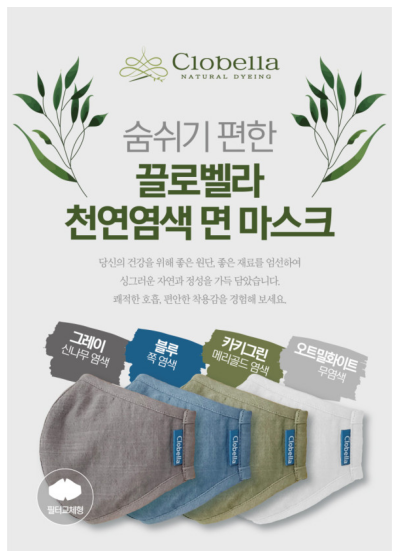

------------------------------------------------------------------------------------------------
추출한 이미지 목록
------------------------------------------------------------------------------------------------


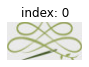

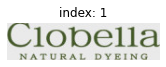

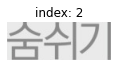

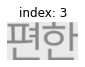

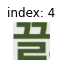

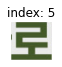

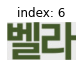

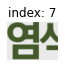

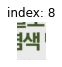

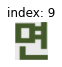

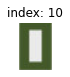

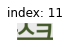

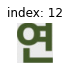

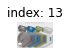

In [9]:
plt.figure(figsize=(10,10))
crop_img_path = './images/ts/test_3/'

print('----'*24)
print('세번째 이미지 원본')
print('----'*24)
img = plt.imread('./images/test_3.jfif')
plt.imshow(img)
plt.axis('off')
plt.show()
print('----'*24)
print('추출한 이미지 목록')
print('----'*24)
for i in range(14):
    if i < 10:
        img = cv2.imread(crop_img_path + '000{}.png'.format(i))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(5, 2, i+1)
        plt.imshow(img)
        plt.title(f'index: {i}')
        plt.axis('off')
        plt.show()
    elif 10 <= i < 100:
        img = cv2.imread(crop_img_path + '00{}.png'.format(i))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(4, 8, i+1)
        plt.imshow(img)
        plt.title(f'index: {i}')
        plt.axis('off')
        plt.show()        

- 숨쉬기 편한, 면, 마스크 이것도 꽤나 추출을 잘했군요.
  
  
- 네번째 이미지는 어떨까요?

------------------------------------------------------------------------------------------------
네번째 이미지 원본
------------------------------------------------------------------------------------------------


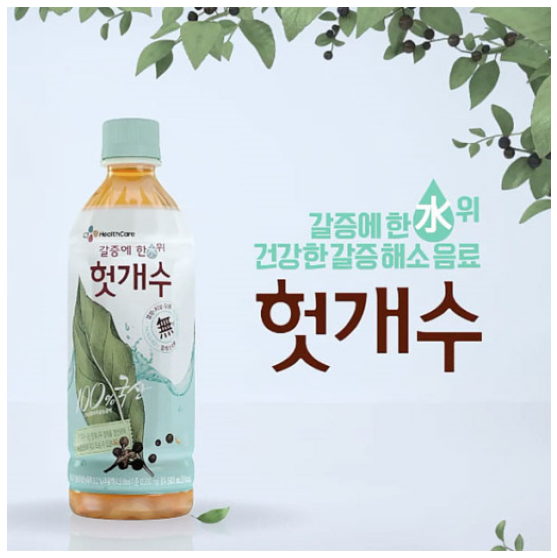

------------------------------------------------------------------------------------------------
추출한 이미지 목록
------------------------------------------------------------------------------------------------


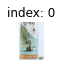

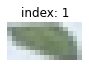

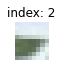

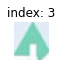

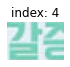

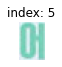

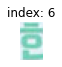

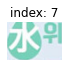

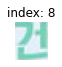

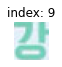

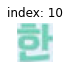

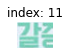

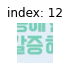

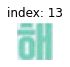

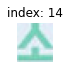

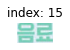

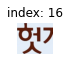

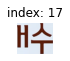

In [10]:
plt.figure(figsize=(10,10))
crop_img_path = './images/ts/test_4/'

print('----'*24)
print('네번째 이미지 원본')
print('----'*24)
img = plt.imread('./images/test_4.jfif')
plt.imshow(img)
plt.axis('off')
plt.show()
print('----'*24)
print('추출한 이미지 목록')
print('----'*24)
for i in range(18):
    if i < 10:
        img = cv2.imread(crop_img_path + '000{}.png'.format(i))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(5, 2, i+1)
        plt.imshow(img)
        plt.title(f'index: {i}')
        plt.axis('off')
        plt.show()
    elif 10 <= i < 100:
        img = cv2.imread(crop_img_path + '00{}.png'.format(i))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(4, 8, i+1)
        plt.imshow(img)
        plt.title(f'index: {i}')
        plt.axis('off')
        plt.show()        

- 갈증, 건강한, 음료, 헛개, 수 이번것도 crop을 꽤 잘했군요.
  
  
- 마지막 사진도 확인해보겠습니다!

------------------------------------------------------------------------------------------------
다섯번째 이미지 원본
------------------------------------------------------------------------------------------------


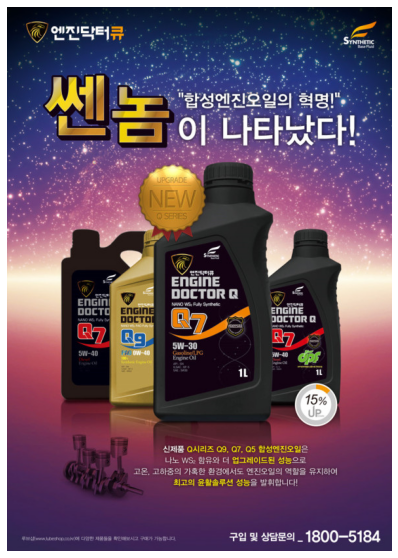

------------------------------------------------------------------------------------------------
추출한 이미지 목록
------------------------------------------------------------------------------------------------


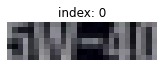

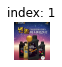

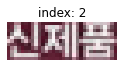

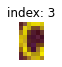

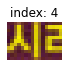

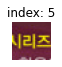

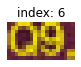

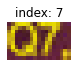

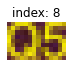

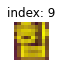

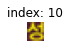

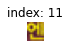

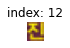

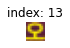

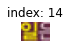

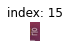

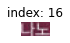

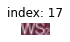

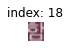

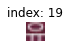

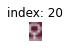

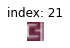

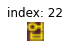

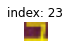

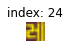

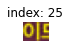

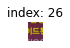

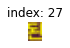

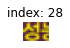

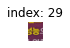

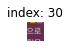

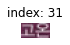

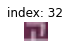

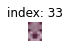

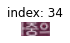

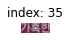

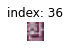

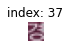

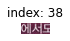

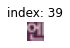

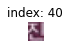

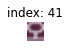

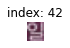

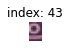

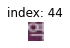

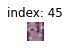

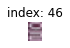

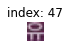

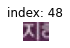

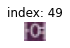

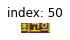

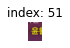

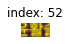

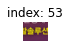

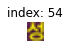

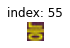

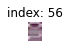

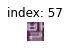

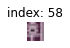

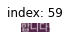

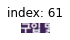

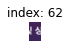

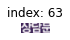

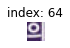

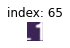

In [11]:
plt.figure(figsize=(10,10))
crop_img_path = './images/ts/test_5/'

print('----'*24)
print('다섯번째 이미지 원본')
print('----'*24)
img = plt.imread('./images/test_5.jfif')
plt.imshow(img)
plt.axis('off')
plt.show()
print('----'*24)
print('추출한 이미지 목록')
print('----'*24)
for i in range(66):
    if i < 10:
        img = cv2.imread(crop_img_path + '000{}.png'.format(i))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(5, 2, i+1)
        plt.imshow(img)
        plt.title(f'index: {i}')
        plt.axis('off')
        plt.show()
    elif 10 <= i < 100:
        img = cv2.imread(crop_img_path + '00{}.png'.format(i))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(10, 10, i+1)
        plt.imshow(img)
        plt.title(f'index: {i}')
        plt.axis('off')
        plt.show()        

- 굉장히 많은 이미지를 추출했군요.
- 엔, 진, 오, 일 등등 crop은 꽤 잘했는데 단어를 다 쪼개서 인식했군요. 그래도 괜찮은 모습을 보여줍니다.

---
## 4. 결과 확인

In [12]:
def recognize_images(file_path, num=0, file_num=0, name=None):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    file_path = file_path + '/test_{}'.format(file_num)
    corpus = []
    
    for i in range(num):
        if i < 10:
            image = Image.open(file_path + '/000{}.png'.format(i))
            recognized_data = pytesseract.image_to_string(
                image, lang='kor',    # 한국어라면 lang='kor'
                config=custom_oem_psm_config,
                output_type=Output.DICT
            )
            recognized_data['text'] = recognized_data['text'].strip('_\nx0c~ㄴ(!|/')
            corpus.append(recognized_data['text'])
        elif 100 > i >= 10:
            image = Image.open(file_path + '/00{}.png'.format(i))
            recognized_data = pytesseract.image_to_string(
                image, lang='kor',    # 한국어라면 lang='kor'
                config=custom_oem_psm_config,
                output_type=Output.DICT
            )
            recognized_data['text'] = recognized_data['text'].strip('_\nx0c~ㄴ(!|/')
            corpus.append(recognized_data['text'])
    print('{}번째 사진 추출 완료'.format(name))
    print('---'*40)
    print("추출한 텍스트 목록: ", corpus)

- 추출한 텍스트 목록을 확인해보는 함수를 만들었습니다.
  
- 한번 확인해보도록 하겠습니다.

In [13]:
file_path = './images/ts'

recognize_images(file_path, 25, 1, name='첫')

첫번째 사진 추출 완료
------------------------------------------------------------------------------------------------------------------------
추출한 텍스트 목록:  ['\x0c', '체엄단신청울하고,다이어트통즐겨보세요.\n\x0c', '\x0c', '\x0c', '구토!\n\x0c', '때\n\x0c', '\x0c', '101!\n\x0c', '는\n\x0c', '센터\n\x0c', '\\\n\x0c', '”\n\x0c', '는\n\x0c', '\x0c', '[9\n\x0c', '\x0c', '\x0c', '램\n\x0c', '체흔\n\x0c', ')\n\x0c', '\x0c', '번트\n\x0c', '\x0c', '\x0c', '\x0c']


- 체엄단신청울하고, 다이어트통즐겨보세요. 라.. 그래도 핵심 단어는 포함되어있군요!
  
- 쓸모없는 \x0c 같은 줄바꿈 문자같은게 리스트형태로 만들다보니 포함되어버렸는데.. 제거하는법을 모르겠습니다. 알아봤는데 지워지지 않더군요.. 무시하고 해야할듯 합니다.

In [14]:
recognize_images(file_path, 18, 2, name='두')

두번째 사진 추출 완료
------------------------------------------------------------------------------------------------------------------------
추출한 텍스트 목록:  ['<\n\x0c', '\x0c', '[2\n\x0c', '로\n\x0c', '\x0c', '고별\n\x0c', '슴살\n\x0c', 'ㅣ\n\x0c', '보\n\x0c', 'ㅣ\n\x0c', '곰노리시될 !\n\x0c', '도\n\x0c', '씨\n\x0c', '그\n\x0c', '\x0c', '[1\n\x0c', '킨하와0|안\n\x0c', '\x0c']


- 분명 아깐 .. 이미지 추출을 잘 했는데요? 왜 텍스트는 이럴까요
- 슴살.. 킨하와이안 .. 무언가 한글자씩 빠진듯한 느낌을 보여줍니다
- bounding box가 제대로 형성되지 못한듯합니다.

In [15]:
recognize_images(file_path, 14, 3, name='세')

세번째 사진 추출 완료
------------------------------------------------------------------------------------------------------------------------
추출한 텍스트 목록:  ['\x0c', '.10126118\n\x0c', '숨수기\n\x0c', '떠이\n\x0c', '글\n\x0c', '=\n\x0c', '벨라\n\x0c', '염^\n\x0c', "색'\n\x0c", '느티\n\x0c', '\x0c', '^\n\x0c', '여\n\x0c', '     ( 7\n\x0c']


- 숨수기.. 느티.. 여기도 똑같이 뭔가 한글자씩 빼먹었군요.
- 특히나 가장 중요한 단어인 마스크가 포함되지 않았습니다.

In [16]:
recognize_images(file_path, 18, 4, name='네')

네번째 사진 추출 완료
------------------------------------------------------------------------------------------------------------------------
추출한 텍스트 목록:  ['\x0c', '아족\n\x0c', '\x0c', '^\n\x0c', '갈수\n\x0c', '\\\n\x0c', 'ㅇ\n\x0c', '위\n\x0c', '271\n\x0c', '27\n\x0c', '안\n\x0c', '갈증\n\x0c', '\x0c', '해\n\x0c', '^\n\x0c', '음료\n\x0c', '언2\n\x0c', '수\n\x0c']


- 갈수.. 위.. 또한 애매합니다. 하지만! 갈증, 음료 라는 핵심 키워드가 포함되어있군요. 그래도 헛개수 사진이 가장 추출이 잘되었군요!

In [17]:
recognize_images(file_path, 66, 5, name='다섯')

다섯번째 사진 추출 완료
------------------------------------------------------------------------------------------------------------------------
추출한 텍스트 목록:  ['1. 21\n\x0c', '\x0c', '신제품\n\x0c', '\x0c', '\x0c', '리즈\n\x0c', '”\n\x0c', '7@\n\x0c', "#'\n\x0c", '합\n\x0c', '성\n\x0c', '1.\n\x0c', '결.\n\x0c', '오\n\x0c', '은\n\x0c', '그\n\x0c', '여아\n\x0c', '으려\n\x0c', '그\n\x0c', '\x0c', '…\n\x0c', '띠\n\x0c', '\x0c', 'ㅣ\n\x0c', '려|\n\x0c', ']:\n\x0c', '1드\n\x0c', '고\n\x0c', '서운.\n\x0c', '사소\n\x0c', '\x0c', '10\n\x0c', '4\n\x0c', '낭"\n\x0c', '우고\n\x0c', '가혹힌\n\x0c', '이\n\x0c', '\x0c', '나서\n\x0c', '1\n\x0c', '나\n\x0c', '노그\n\x0c', '\x0c', '…\n\x0c', '\x0c', '일\n\x0c', '노\n\x0c', '\x0c', '차,\n\x0c', '10;\n\x0c', '최고의\n\x0c', '득\n\x0c', '수스\n\x0c', '솔루선\n\x0c', '2,\n\x0c', '3\n\x0c', '\x0c', '발\n\x0c', '2\n\x0c', '합니다!\n\x0c', '6” 0 ㅣ 이 니닐빈 나 ㅋㅋ 나시! 고대 기 아는형\n\x0c', '4 로:\n\x0c', '볼\n\x0c', '상담운\n\x0c', '의\n\x0c', '저\n\x0c']


- 이미지는 가장 많이 추출하더니.. 영양가있는 텍스트가 거의 없어보입니다. 신제품, 합, 성 이정도일까요? 가장 중요한 키워드인 엔진오일이 들어있지않습니다. 이 또한 추출이 잘못된듯 합니다.

---
## 5. 결과 요약

In [18]:
def print_orig_img(img_path, num=0):
    plt.figure(figsize=(10,10))
    img = cv2.imread(img_path + '/test_{}.jfif'.format(num))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

- 원본 이미지를 출력해주는 함수를 만들었습니다.
  
  
- 원본 이미지와 텍스트를 함께 비교해보도록 하겠습니다.

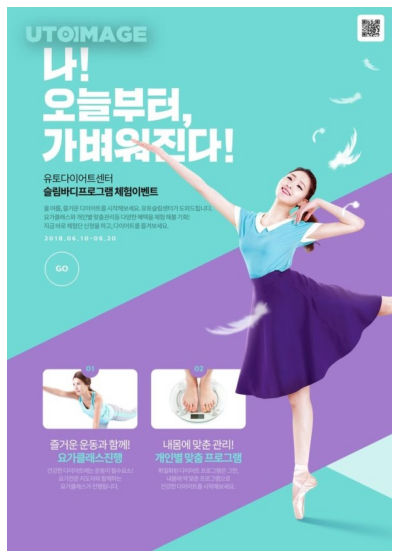

첫번째 사진 추출 완료
------------------------------------------------------------------------------------------------------------------------
추출한 텍스트 목록:  ['\x0c', '체엄단신청울하고,다이어트통즐겨보세요.\n\x0c', '\x0c', '\x0c', '구토!\n\x0c', '때\n\x0c', '\x0c', '101!\n\x0c', '는\n\x0c', '센터\n\x0c', '\\\n\x0c', '”\n\x0c', '는\n\x0c', '\x0c', '[9\n\x0c', '\x0c', '\x0c', '램\n\x0c', '체흔\n\x0c', ')\n\x0c', '\x0c', '번트\n\x0c', '\x0c', '\x0c', '\x0c']


In [19]:
img_path = './images'

print_orig_img(img_path, num = 1)
recognize_images(file_path, num = 25, file_num = 1, name='첫')

- 흠.. 어떻게된것인지 큰 글씨들은 남겨놓고 가장 조그마한 글씨인 체험단 신청을 하고 다이어트를 즐겨보세요. 라는 문구만 추출하였습니다.

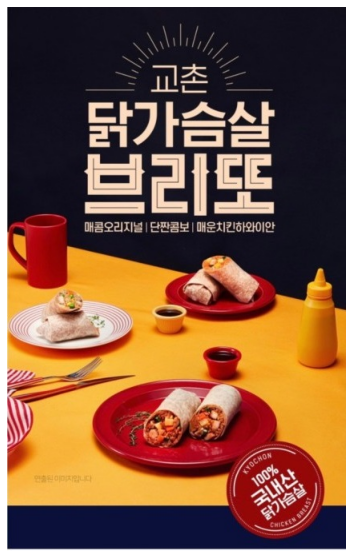

두번째 사진 추출 완료
------------------------------------------------------------------------------------------------------------------------
추출한 텍스트 목록:  ['<\n\x0c', '\x0c', '[2\n\x0c', '로\n\x0c', '\x0c', '고별\n\x0c', '슴살\n\x0c', 'ㅣ\n\x0c', '보\n\x0c', 'ㅣ\n\x0c', '곰노리시될 !\n\x0c', '도\n\x0c', '씨\n\x0c', '그\n\x0c', '\x0c', '[1\n\x0c', '킨하와0|안\n\x0c', '\x0c']


In [20]:
print_orig_img(img_path, num = 2)
recognize_images(file_path, num = 18, file_num = 2, name='두')

- 역시나 한글자씩 빠진듯한 슴살, 킨하와이안 등을 보여주는군요
- 왜 가장 큰 글씨인 브리또, 닭가슴살같은 문구를 추출하지 못했을까요?

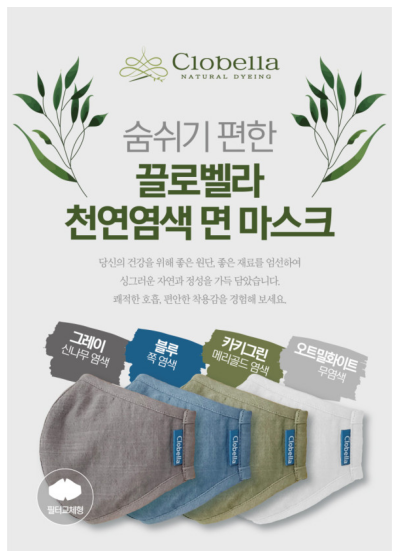

세번째 사진 추출 완료
------------------------------------------------------------------------------------------------------------------------
추출한 텍스트 목록:  ['\x0c', '.10126118\n\x0c', '숨수기\n\x0c', '떠이\n\x0c', '글\n\x0c', '=\n\x0c', '벨라\n\x0c', '염^\n\x0c', "색'\n\x0c", '느티\n\x0c', '\x0c', '^\n\x0c', '여\n\x0c', '     ( 7\n\x0c']


In [21]:
print_orig_img(img_path, num = 3)
recognize_images(file_path, num = 14, file_num = 3, name='세')

- 숨수기 같은 단어는 있으나.. 역시나 가장 중요한 마스크가 없습니다.

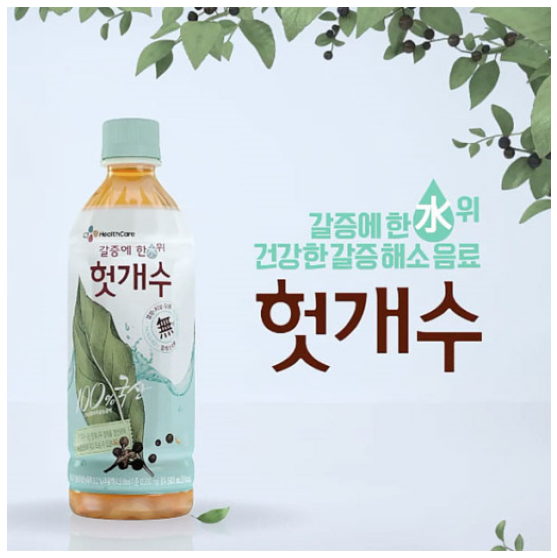

네번째 사진 추출 완료
------------------------------------------------------------------------------------------------------------------------
추출한 텍스트 목록:  ['\x0c', '아족\n\x0c', '\x0c', '^\n\x0c', '갈수\n\x0c', '\\\n\x0c', 'ㅇ\n\x0c', '위\n\x0c', '271\n\x0c', '27\n\x0c', '안\n\x0c', '갈증\n\x0c', '\x0c', '해\n\x0c', '^\n\x0c', '음료\n\x0c', '언2\n\x0c', '수\n\x0c']


In [22]:
print_orig_img(img_path, num = 4)
recognize_images(file_path, num = 18, file_num = 4, name='네')

- 헛개수는 갈증, 음료 같은 핵심 키워드를 잘 추출했습니다. 대신 상품명인 헛개수를 추출하진 못했군요.

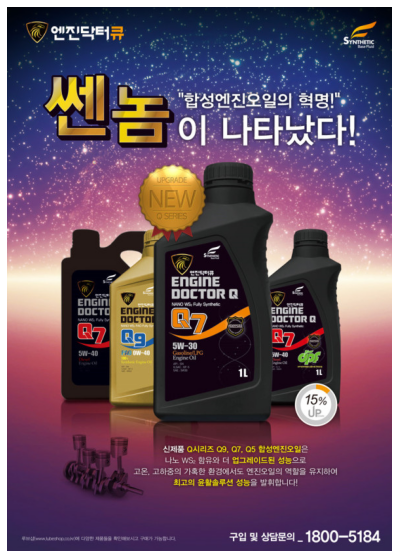

다섯번째 사진 추출 완료
------------------------------------------------------------------------------------------------------------------------
추출한 텍스트 목록:  ['1. 21\n\x0c', '\x0c', '신제품\n\x0c', '\x0c', '\x0c', '리즈\n\x0c', '”\n\x0c', '7@\n\x0c', "#'\n\x0c", '합\n\x0c', '성\n\x0c', '1.\n\x0c', '결.\n\x0c', '오\n\x0c', '은\n\x0c', '그\n\x0c', '여아\n\x0c', '으려\n\x0c', '그\n\x0c', '\x0c', '…\n\x0c', '띠\n\x0c', '\x0c', 'ㅣ\n\x0c', '려|\n\x0c', ']:\n\x0c', '1드\n\x0c', '고\n\x0c', '서운.\n\x0c', '사소\n\x0c', '\x0c', '10\n\x0c', '4\n\x0c', '낭"\n\x0c', '우고\n\x0c', '가혹힌\n\x0c', '이\n\x0c', '\x0c', '나서\n\x0c', '1\n\x0c', '나\n\x0c', '노그\n\x0c', '\x0c', '…\n\x0c', '\x0c', '일\n\x0c', '노\n\x0c', '\x0c', '차,\n\x0c', '10;\n\x0c', '최고의\n\x0c', '득\n\x0c', '수스\n\x0c', '솔루선\n\x0c', '2,\n\x0c', '3\n\x0c', '\x0c', '발\n\x0c', '2\n\x0c', '합니다!\n\x0c', '6” 0 ㅣ 이 니닐빈 나 ㅋㅋ 나시! 고대 기 아는형\n\x0c', '4 로:\n\x0c', '볼\n\x0c', '상담운\n\x0c', '의\n\x0c', '저\n\x0c']


In [23]:
print_orig_img(img_path, num = 5)
recognize_images(file_path, num = 66, file_num = 5, name='다섯')

- 처참합니다... 뭐 제대로 된 텍스트가 하나도 없습니다. 항상 그렇듯 최상단의 큰 글씨들을 못읽는 경향을 보입니다.

---
## 6. 회고

### 이번 프로젝트를 하면서 어려웠던 점
>- 모르는 함수들이 많아 생각보다 어려웠습니다. LMS에서 실습 진행할 때엔 생각보다 쉬웠기에 이번 프로젝트는 쉬운데? 라고 생각했으나 오산이었습니다.. 중간중간 안돌아가는 함수도 많았으며 한글도 지원이 안되고 특히나 bounding box를 제멋대로 그리는데다 그 bounding box 안에서조차 텍스트 추출을 못하니.. 성능 개선을 해보려했지만 이정도에 그치게 되었습니다.

### 이번 프로젝트에서 학습한 내용
>- Image 모듈, PIL 라이브러리, cv2 같은 평소 어려웠던 이미지 관련 모듈들을 많이 사용해본것이 도움이 되었습니다. cv가 저와 성향이 많이 맞지않아 항상 피하기만 했었는데 이렇게 억지로라도 사용해보니 어느정도 감이 잡힌것 같다고 생각합니다.

### 알아낸 점이나 모호한 점
>- 알아낸 점은 특별하게 많지는 않으나 각 Image 모듈, PIL 라이브러리, cv2 라이브러리 등 라이브러리 내 모듈들의 기능과 같은 부분에 대해 많이 알게되었습니다. 실전에서 사용해보진 못했지만 그래도 의미정도는 파악할 수는 있을 것 같습니다.
>  
>
>- 모호한 점이라면 아직 테서렉트 사용법이 어렵습니다. 특히 oem, psm 같은 키워드들의 내용이 아직 난해합니다. 어느정도 감은 있으나 사용해보려 하면 오류가 뜨는 모양을 보여줘 응용은 어려웠습니다.


### 루브릭 평가지표를 맞추기 위해 노력했던 점
>- __1. 기획한 서비스가 OCR 적용 가능한 서비스이며, OCR 기술을 활용했을 때 더 유용한지에 대한 타당성 여부를 기술하였다.__ 에 대해서는 기획한 서비스는 무작위 크롤링 데이터 중 광고 이미지를 통한 카테고리 분류를 목적으로 하였습니다. 마케팅 분야에서 사용한다면 상당히 유용할것 같습니다.
>- __2. 앞서 기획한 서비스에서 OCR 모델들이 그 목적에 부합하는지 확인하기 위해 필요한 평가 기준을 제시하고, 평가기준에 적합한 테스트 데이터의 특징이 무엇인지 설명하였다.__ 에 대한 평가기준으로는 __이미지 내에서 무엇을 설명하는지에 대한 핵심 키워드 추출__ 을 평가 기준으로 두었습니다. 1번 사진을 예시로 든다면 다이어트, 2번 사진은 교촌, 닭가슴살, 브리또. 3번 사진은 마스크, 4번 사진은 갈증, 음료, 5번 사진은 오일 등을 핵심 키워드로 설정하였으나 생각보다 좋은 성능은 이끌어내지 못했습니다.
>- __3. 최대 20장까지의 테스트 이미지를 사용해 제시된 평가 기준에 따른 테스트 결과가 잘 정리되어 결론이 도출되었다.__ 에 대해서는 이미지 갯수를 15장까지 사용해보았으나 keras_ocr 에서 prediction_image 를 추출하는 과정에서 커널이 죽거나 메모리 오류가 나는 이슈로 인해서 5장밖에 사용하지 못하였습니다. 제시된 평가 기준에 따라 테스트 결과를 정리해 보았으나 결론으론 평가기준을 만족하지 못했다. 입니다.

### 루브릭 평가지표를 달성하지 못했다면 이유
>- 솔직히 이번 프로젝트는 1,2,3번 모두 애매합니다. 상당히 주관적이기도 하며 성능개선의 방법을 도저히 찾을 수가 없었습니다. 여러 방법을 시도해서 사진 이미지를 키우거나 줄여도 보고 crop 이미지 사이즈 조절도 해보고 해당 제품이 아닌 경고표지판, 음식점 간판, 메뉴판, 영수증 등 다양한 카테고리로 도전해보았으나 모두 좋은 성능을 보여주지 못했습니다. 루브릭을 달성하지 못했다면 아마 이러한 이유때문에 그렇지 않을까 추측해봅니다.


---
### 7. Reference

- https://pillow.readthedocs.io/en/stable/reference/Image.html PIL 공식문서
- https://keras-ocr.readthedocs.io/en/latest/ keras_ocr 공식문서

---
## 8. 자기다짐 및 아쉬운 점

- 제가 cv task에 상당히 약한 모습을 보여주는데 이번 프로젝트는 생각보다 쉬운 모습에 가능하겠구나! 라고 생각했었으나 오산이었습니다. 쉽지 않았고 역시나 cv task는 어려웠으며 어느정도 이해했다고 생각했으나 응용하지 못했습니다.
  
  
- 이제 NLP 분야로 결정이 되었지만 역시나 CV도 함께 공부해야겠구나 하는 생각이듭니다. 이번 프로젝트처럼 cv와 nlp가 함께 진행할 수 있는 프로젝트들이 꽤 있구나라는 생각으로 생각의 범위를 넓혀야할듯 합니다.